In [1]:
from matplotlib import pyplot as plt
import pymatching # Decoding
from circuit_generators import *
from sampling_functions import *
import numpy as np
from copy import deepcopy

# Also define the number of worker nodes here
n_worker_nodes = 8

# Surface code specifications
d = 4
r = 2
p = 0.01
use_rotated_z = True

# Bit types
binary_t = np.int8 # Could use even less if numpy allowed
packed_t = np.int8 # Packed bit type
if d<=8:
  pass
elif d>8 and d<=16:
  packed_t = np.int16
elif d>16 and d<=32:
  packed_t = np.int32
elif d>32 and d<=64:
  packed_t = np.int64
elif d>64 and d<=128:
  packed_t = np.int128
elif d>128 and d<=256:
  packed_t = np.int256
else:
  raise RuntimeError("d is too large.")
time_t = np.int8

# Measurement index type
idx_t = np.int8
n_all_measurements = r*(d**2-1) + d**2
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int16
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int32
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int64
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int128
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int256
if n_all_measurements > np.iinfo(idx_t).max:
  raise RuntimeError("idx_t is too small.")

Average flip rate: 0.1916032
QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 1) 7
QUBIT_COORDS(1, 3) 10
QUBIT_COORDS(2, 2) 11
QUBIT_COORDS(3, 3) 12
QUBIT_COORDS(4, 2) 13
QUBIT_COORDS(5, 3) 14
QUBIT_COORDS(6, 2) 15
QUBIT_COORDS(7, 3) 16
QUBIT_COORDS(0, 4) 18
QUBIT_COORDS(1, 5) 19
QUBIT_COORDS(2, 4) 20
QUBIT_COORDS(3, 5) 21
QUBIT_COORDS(4, 4) 22
QUBIT_COORDS(5, 5) 23
QUBIT_COORDS(6, 4) 24
QUBIT_COORDS(7, 5) 25
QUBIT_COORDS(8, 4) 26
QUBIT_COORDS(1, 7) 28
QUBIT_COORDS(2, 6) 29
QUBIT_COORDS(3, 7) 30
QUBIT_COORDS(4, 6) 31
QUBIT_COORDS(5, 7) 32
QUBIT_COORDS(6, 6) 33
QUBIT_COORDS(7, 7) 34
QUBIT_COORDS(2, 8) 38
QUBIT_COORDS(6, 8) 42
R 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
X_ERROR(0.01) 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
R 2 6 11 13 15 18 20 22 24 26 29 31 33 38 42
X_ERROR(0.01) 2 6 11 13 15 18 20 22 24 26 29 31 33 38 42
TICK
DEPOLARIZE1(0.01) 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
H 2 6 13 20 24 31 38 4

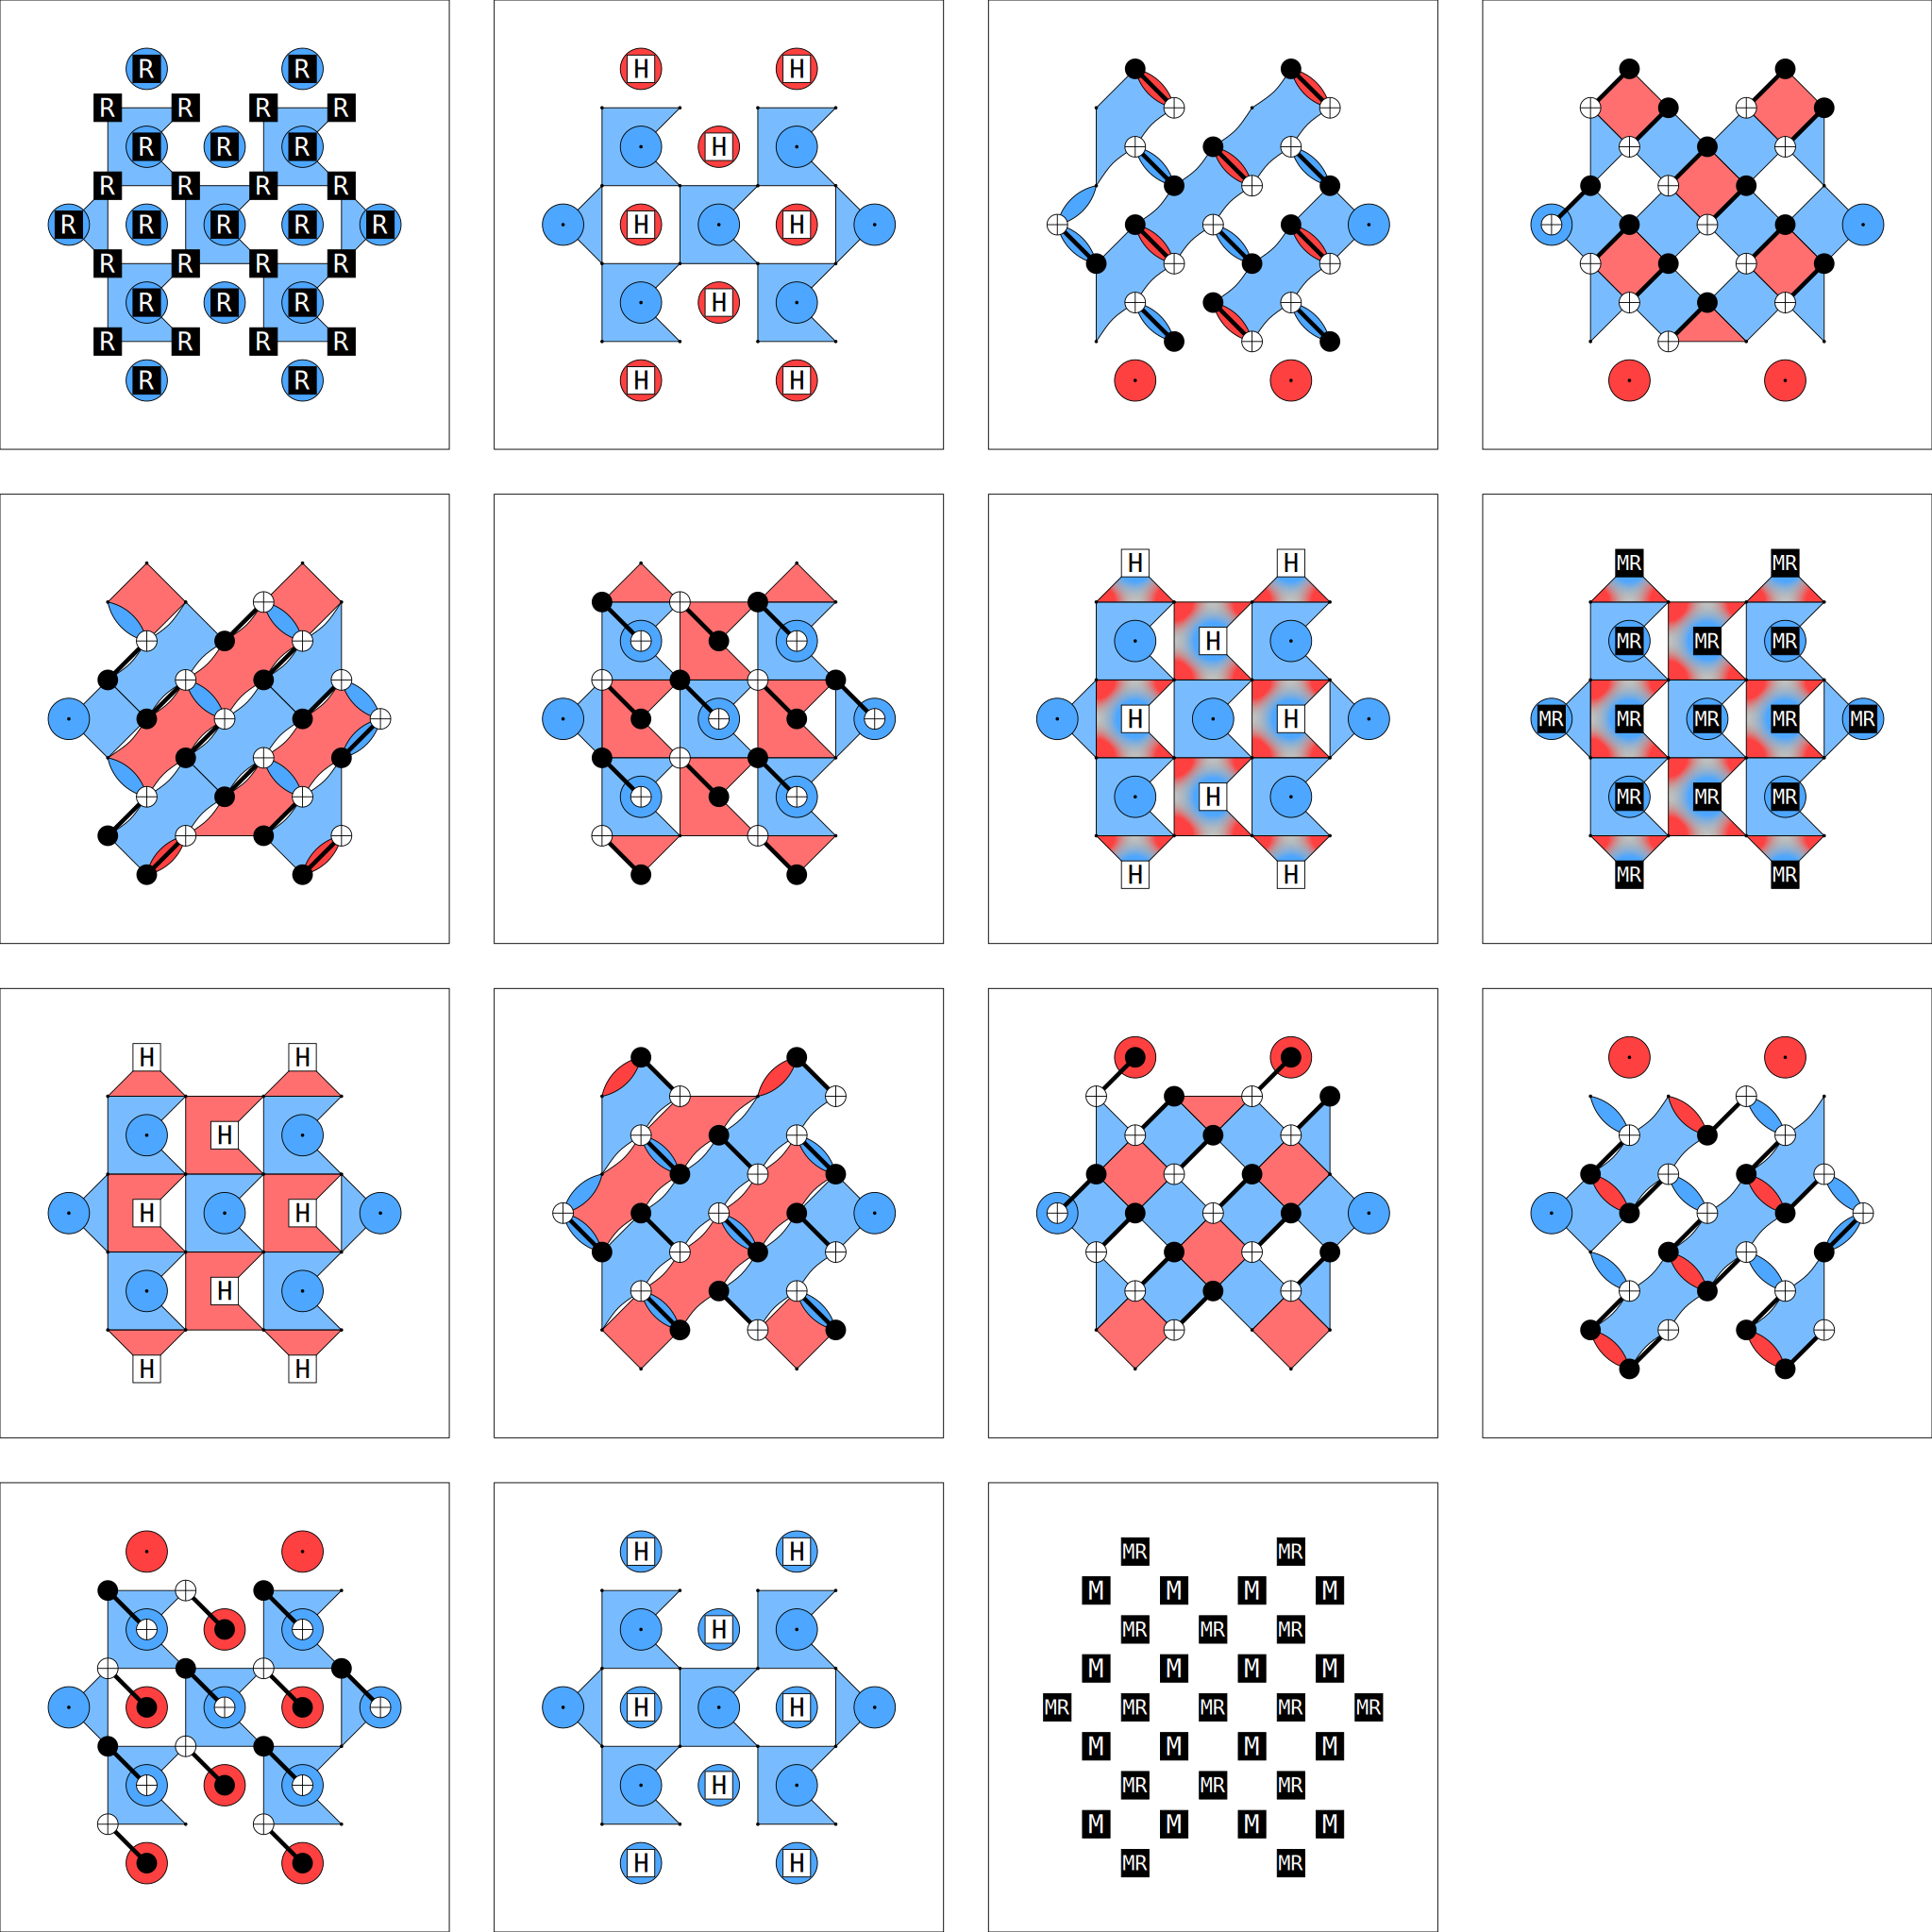

In [2]:
n_samples = 10000000
decoders = ['pymatching']
test_circuit = get_builtin_circuit(
  "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
  distance=d,
  rounds=r,
  before_round_data_depolarization = p,
  after_reset_flip_probability = p,
  after_clifford_depolarization = p,
  before_measure_flip_probability = p
)
m_sampler = test_circuit.compile_sampler(seed=12345)
d_sampler = test_circuit.compile_detector_sampler(seed=12345)
converter = test_circuit.compile_m2d_converter()

measurements = m_sampler.sample(n_samples, bit_packed=False)
det_evts, flips = converter.convert(measurements=measurements, separate_observables=True, bit_packed=False)
measurements = measurements.astype(binary_t)
det_evts = det_evts.astype(binary_t)
flips = flips.astype(binary_t)

avg_flips = np.sum(flips.reshape(-1,), dtype=np.float32)/flips.shape[0]
print(f"Average flip rate: {avg_flips}")

print(test_circuit)
test_circuit.without_noise().diagram('detslice-with-ops-svg')

In [3]:
n_measurements = idx_t(measurements.shape[1])
exclude_indices = np.array([-x-1 for x in range(d**2)], dtype=idx_t)
exclude_indices = exclude_indices + n_measurements
exclude_indices_obsL = np.array([-x-1 for x in range(d*(d-1), d**2)], dtype=idx_t)
exclude_indices_obsL = exclude_indices_obsL + n_measurements
exclude_indices_obs = np.arange(0, n_measurements, 1, dtype=idx_t)
exclude_indices_obs = np.delete(exclude_indices_obs, exclude_indices_obsL)

det_bits = measurements
det_bits = np.delete(det_bits, exclude_indices, axis=1)
obs_bits = measurements
obs_bits = np.delete(obs_bits, exclude_indices_obs, axis=1)
print(obs_bits)

[[1 0 1 0]
 [1 1 1 1]
 [0 1 0 1]
 ...
 [0 0 1 1]
 [1 0 1 1]
 [0 0 0 1]]


In [4]:
detector_error_model = test_circuit.detector_error_model(decompose_errors=True)
pymatcher = pymatching.Matching.from_detector_error_model(detector_error_model)
predictions_pym = pymatcher.decode_batch(det_evts, bit_packed_predictions=False, bit_packed_shots=False)
predictions_pym = predictions_pym.astype(packed_t)

incorrect_matches = (predictions_pym != flips)
incorrect_pym_rate = np.sum(incorrect_matches.reshape(-1,), dtype=np.float32)/incorrect_matches.shape[0]
print(f"PyMatching error rate: {incorrect_pym_rate}")

PyMatching error rate: 0.043677


In [5]:
# Prepare the input for training
class_bits = obs_bits
class_bits_wpym = np.concatenate((obs_bits, incorrect_matches), axis=1)
print(class_bits)

feature_bits = np.concatenate((det_bits, det_evts), axis=1)
feature_bits_wpym = np.concatenate((det_bits, det_evts, predictions_pym), axis=1)
print(feature_bits[0])

def bit_pack_bits(ev_bits):
  res: packed_t = 0
  for i in range(ev_bits.shape[0]):
    res = res | (packed_t(ev_bits[i]) << i)
  return res

class_bits_packed = np.zeros(class_bits.shape[0], dtype=packed_t)
class_bits_wpym_packed = np.zeros(class_bits_wpym.shape[0], dtype=packed_t)
for iev in range(class_bits.shape[0]):
  class_bits_packed[iev] = bit_pack_bits(class_bits[iev])
  class_bits_wpym_packed[iev] = bit_pack_bits(class_bits_wpym[iev])

[[1 0 1 0]
 [1 1 1 1]
 [0 1 0 1]
 ...
 [0 0 1 1]
 [1 0 1 1]
 [0 0 0 1]]
[0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0]


In [6]:
from utilities_tf import *
test_fraction = 5./10.
feature_bits_train, feature_bits_test, \
  class_bits_train, class_bits_test, \
  feature_bits_train_wpym, feature_bits_test_wpym, \
  class_bits_train_wpym, class_bits_test_wpym, \
  incorrect_matches_train, incorrect_matches_test \
  = split_data(feature_bits, class_bits_packed, feature_bits_wpym, class_bits_wpym_packed, incorrect_matches, test_size=test_fraction)

Build models with 2 dense layers with an equal number `nn` of nodes:
- `nn` ranges from 40 to 120 in steps of 10
- One set of models (`models_wpym`) use only the bits for (syndrome measurements) (x) (detection events) (same inherent information but apparently helps with training: https://arxiv.org/abs/2310.05900) as features. The labels are the (bitmap of d(=4) measurements) for which we are eventually looking for an even or odd XOR result.
- In the other set (`models_wpym`), we use bit the bits for (syndrome measurements) (x) (detection events) (x) (one extra bit for the flag from pyMatching that predicts a flip in the XOR result). The labels are the (bitmap of d(=4) measurements) (x) (one bit to flag an incorrect pyMatching prediction).

In this way, any measurement of observable significance ends up being a label for the NN to predict. Any measurement that directly or indirectly relates to the set of syndrome measurements ends up in input features.

Things we could also do is to adjust the layer 1 : layer 2 ratio of the number of nodes, or change the number of layers altogether.

In [7]:
nnodes = [ 150 ]
nlayers = 2
models_nnonly = []
models_wpym = []
models_onlypym = []
for nn in nnodes:
  node_arg = [ (nn, 8) for _ in range(nlayers) ]

  models_nnonly.append(
    build_sequential_qdense_model(
      feature_bits.shape[1], pow(2, class_bits.shape[1]),
      node_arg,
      loss_fcn = "sparse_categorical_crossentropy",
      output_activation = "softmax"
    )
  )
  models_wpym.append(
    build_sequential_qdense_model(
      feature_bits_wpym.shape[1], pow(2, class_bits_wpym.shape[1]),
      node_arg,
      loss_fcn = "sparse_categorical_crossentropy",
      output_activation = "softmax"
    )
  )
  models_onlypym.append(
    build_sequential_qdense_model(
      feature_bits_wpym.shape[1], pow(2, incorrect_matches.shape[1]),
      node_arg,
      loss_fcn = "sparse_categorical_crossentropy",
      output_activation = "softmax"
    )
  )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense (QDense)            (None, 150)               9000      
                                                                 
 q_dense_1 (QDense)          (None, 150)               22650     
                                                                 
 q_dense_2 (QDense)          (None, 16)                2416      
                                                                 
Total params: 34066 (133.07 KB)
Trainable params: 34066 (133.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense_3 (QDense)          (None, 150)               9150      
                                                                 
 q_dense_4 (QDense)          (None, 150)               22650     
                                                                 
 q_dense_5 (QDense)          (None, 32)                4832      
                                                                 
Total params: 36632 (143.09 KB)
Trainable params: 36632 (143.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense_6 (QDense)          (None, 150)               9150      
                                                            

Train the models with no pyMatching input:

In [8]:
i=0
val_split = 0.2
n_epochs = 25
for model in models_nnonly:
  print(f"Training the model with n_dense = ({nnodes[i]}, {nnodes[i]}) layers:")
  history = model.fit(feature_bits_train, class_bits_train, epochs=n_epochs, batch_size=10000, validation_split=val_split)
  # In this test case, looking at the values of accuracies is not informative,
  # but comparing their values between training and testing data sets still tells us about overtraining.
  test_model(model, feature_bits_train, class_bits_train, feature_bits_test, class_bits_test)
  i=i+1
i=0

Training the model with n_dense = (150, 150) layers:
Epoch 1/25



400/400 [==============================] - 44s 105ms/step - loss: 2.3936 - accuracy: 0.1086 - val_loss: 2.2804 - val_accuracy: 0.1151
Epoch 2/25
400/400 [==============================] - 36s 91ms/step - loss: 2.2442 - accuracy: 0.1176 - val_loss: 2.2191 - val_accuracy: 0.1175
Epoch 3/25
400/400 [==============================] - 35s 87ms/step - loss: 2.2079 - accuracy: 0.1194 - val_loss: 2.1998 - val_accuracy: 0.1191
Epoch 4/25
400/400 [==============================] - 36s 91ms/step - loss: 2.1955 - accuracy: 0.1200 - val_loss: 2.1921 - val_accuracy: 0.1189
Epoch 5/25
400/400 [==============================] - 40s 101ms/step - loss: 2.1893 - accuracy: 0.1207 - val_loss: 2.1878 - val_accuracy: 0.1199
Epoch 6/25
400/400 [==============================] - 40s 100ms/step - loss: 2.1857 - accuracy: 0.1211 - val_loss: 2.1850 - val_accuracy: 0.1198
Epoch 7/25
400/400 [==============================] - 37s 93ms/step - loss: 2.1834 - accuracy: 0.1211 - val_loss: 2.1837 - val_accuracy: 0.1195


Define a function to translate the bits back to the XOR result:

In [9]:
def get_XOR_prediction(bitmap):
  """
  Assumes that the first d bits correspond to the observable bits that construct the XOR.
  """
  bitsum=0
  for i in range(d):
    bitsum = bitsum + ((bitmap>>i)&1)
  return bitsum%2
def get_pym_error(bitmap, nbits):
  """
  Assumes the last bit is a prediction for incorrect PyMatching decoder result.
  """
  return (bitmap>>(nbits-1))&1

Train the models with PyMatching input:

In [10]:
i=0
val_split = 0.2
n_epochs = 25
for model in models_wpym:
  print(f"Training the model with n_dense = ({nnodes[i]}, {nnodes[i]}) layers:")
  history = model.fit(feature_bits_train_wpym, class_bits_train_wpym, epochs=n_epochs, batch_size=10000, validation_split=val_split)
  test_model(model, feature_bits_train_wpym, class_bits_train_wpym, feature_bits_test_wpym, class_bits_test_wpym)
  i=i+1
i=0

Training the model with n_dense = (150, 150) layers:
Epoch 1/25
400/400 [==============================] - 34s 83ms/step - loss: 2.3284 - accuracy: 0.1157 - val_loss: 2.2194 - val_accuracy: 0.1195
Epoch 2/25
400/400 [==============================] - 33s 82ms/step - loss: 2.2110 - accuracy: 0.1200 - val_loss: 2.2057 - val_accuracy: 0.1198
Epoch 3/25
400/400 [==============================] - 32s 81ms/step - loss: 2.2013 - accuracy: 0.1207 - val_loss: 2.1986 - val_accuracy: 0.1195
Epoch 4/25
400/400 [==============================] - 35s 87ms/step - loss: 2.1954 - accuracy: 0.1209 - val_loss: 2.1938 - val_accuracy: 0.1194
Epoch 5/25
400/400 [==============================] - 34s 84ms/step - loss: 2.1910 - accuracy: 0.1210 - val_loss: 2.1904 - val_accuracy: 0.1202
Epoch 6/25
400/400 [==============================] - 32s 81ms/step - loss: 2.1882 - accuracy: 0.1212 - val_loss: 2.1879 - val_accuracy: 0.1189
Epoch 7/25
400/400 [==============================] - 33s 82ms/step - loss: 2.1864 

In [11]:
i=0
val_split = 0.2
n_epochs = 25
for model in models_onlypym:
  print(f"Training the model with n_dense = ({nnodes[i]}, {nnodes[i]}) layers:")
  history = model.fit(feature_bits_train_wpym, incorrect_matches_train, epochs=n_epochs, batch_size=10000, validation_split=val_split)
  test_model(model, feature_bits_train_wpym, incorrect_matches_train, feature_bits_test_wpym, incorrect_matches_test)
  i=i+1
i=0

Training the model with n_dense = (150, 150) layers:
Epoch 1/25
400/400 [==============================] - 45s 109ms/step - loss: 0.1475 - accuracy: 0.9543 - val_loss: 0.1251 - val_accuracy: 0.9562
Epoch 2/25
400/400 [==============================] - 37s 92ms/step - loss: 0.1200 - accuracy: 0.9563 - val_loss: 0.1166 - val_accuracy: 0.9565
Epoch 3/25
400/400 [==============================] - 37s 92ms/step - loss: 0.1133 - accuracy: 0.9567 - val_loss: 0.1114 - val_accuracy: 0.9570
Epoch 4/25
400/400 [==============================] - 44s 110ms/step - loss: 0.1093 - accuracy: 0.9573 - val_loss: 0.1085 - val_accuracy: 0.9576
Epoch 5/25
400/400 [==============================] - 32s 81ms/step - loss: 0.1068 - accuracy: 0.9578 - val_loss: 0.1065 - val_accuracy: 0.9581
Epoch 6/25
400/400 [==============================] - 34s 86ms/step - loss: 0.1050 - accuracy: 0.9583 - val_loss: 0.1051 - val_accuracy: 0.9585
Epoch 7/25
400/400 [==============================] - 35s 87ms/step - loss: 0.103

In [12]:
def extract_flip_info_from_model(model, features_train, features_test, truth_bits_train, truth_bits_test, nbits, do_flips, do_pym):
  flips_truth_train = np.zeros(truth_bits_train.shape[0], dtype=binary_t)
  flips_truth_test = np.zeros(truth_bits_test.shape[0], dtype=binary_t)
  flips_pred_train = np.zeros(truth_bits_train.shape[0], dtype=binary_t)
  flips_pred_test = np.zeros(truth_bits_test.shape[0], dtype=binary_t)
  incorrect_pym_pred_train = np.zeros(truth_bits_train.shape[0], dtype=binary_t)
  incorrect_pym_pred_test = np.zeros(truth_bits_test.shape[0], dtype=binary_t)
  tmp = model.predict(features_train, batch_size=10000)
  for i in range(tmp.shape[0]):
    jp = 0
    vjp = 0.
    for j in range(tmp.shape[1]):
      if tmp[i][j]>vjp:
        vjp = tmp[i][j]
        jp = j
    if do_flips:
      flips_truth_train[i] = get_XOR_prediction(truth_bits_train[i])
      flips_pred_train[i] = get_XOR_prediction(jp)
    if do_pym:
      incorrect_pym_pred_train[i] = get_pym_error(jp, nbits)
    
  tmp = model.predict(features_test, batch_size=10000)
  for i in range(tmp.shape[0]):
    jp = 0
    vjp = 0.
    for j in range(tmp.shape[1]):
      if tmp[i][j]>vjp:
        vjp = tmp[i][j]
        jp = j
    if do_flips:
      flips_truth_test[i] = get_XOR_prediction(truth_bits_test[i])
      flips_pred_test[i] = get_XOR_prediction(jp)
    if do_pym:
      incorrect_pym_pred_test[i] = get_pym_error(jp, nbits)

  if do_flips and not do_pym:
    return flips_truth_train, flips_truth_test, flips_pred_train, flips_pred_test
  elif do_pym and not do_flips:
    return incorrect_pym_pred_train, incorrect_pym_pred_test
  else:
    return flips_truth_train, flips_truth_test, flips_pred_train, flips_pred_test, incorrect_pym_pred_train, incorrect_pym_pred_test

Produce the flip predictions:

In [13]:
flips_truth_train=None
flips_truth_test=None
flips_pred_nnonly_train=None
flips_pred_nnonly_test=None
flips_pred_wpym_train=None
flips_pred_wpym_test=None
incorrect_pym_pred_wpym_train=None
incorrect_pym_pred_wpym_test=None
incorrect_pym_pred_onlypym_train=None
incorrect_pym_pred_onlypym_test=None

flips_truth_train, flips_truth_test, flips_pred_nnonly_train, flips_pred_nnonly_test \
  = extract_flip_info_from_model(models_nnonly[0], feature_bits_train, feature_bits_test, class_bits_train, class_bits_test, class_bits.shape[1], True, False)

_, _, flips_pred_wpym_train, flips_pred_wpym_test, incorrect_pym_pred_wpym_train, incorrect_pym_pred_wpym_test \
  = extract_flip_info_from_model(models_wpym[0], feature_bits_train_wpym, feature_bits_test_wpym, class_bits_train_wpym, class_bits_test_wpym, class_bits_wpym.shape[1], True, True)

incorrect_pym_pred_onlypym_train, incorrect_pym_pred_onlypym_test \
  = extract_flip_info_from_model(models_onlypym[0], feature_bits_train_wpym, feature_bits_test_wpym, incorrect_matches_train, incorrect_matches_test, incorrect_matches.shape[1], False, True)

500/500 [==============================] - 22s 44ms/step


Produce confusion matrices

In [96]:
from sklearn.metrics import confusion_matrix
import itertools

predictions_pym_train = feature_bits_train_wpym[:, -1].reshape(feature_bits_train_wpym.shape[0],)
predictions_pym_test = feature_bits_test_wpym[:, -1].reshape(feature_bits_test_wpym.shape[0],)

normalize_confMat = True
def get_confMat(flips_truth, flips_pred, norm = None):
  confMat = confusion_matrix(flips_truth, flips_pred)
  if norm is not None:
    if norm == 1:
      confMat = confMat.astype(np.float32) / confMat.sum(axis=1)[:, np.newaxis]
    else:
      confMat = confMat.astype(np.float32) / confMat.sum(axis=0)[np.newaxis, :]
  return confMat

confMat_nnonly_test_condTruth = get_confMat(flips_truth_test, flips_pred_nnonly_test, 1)
confMat_wpym_test_condTruth = get_confMat(flips_truth_test, flips_pred_wpym_test, 1)
confMat_wpym_pym_test_condTruth = get_confMat(incorrect_matches_test, incorrect_pym_pred_wpym_test, 1)
confMat_onlypym_test_condTruth = get_confMat(incorrect_matches_test, incorrect_pym_pred_onlypym_test, 1)

confMat_nnonly_test_condPred = get_confMat(flips_truth_test, flips_pred_nnonly_test, 0)
confMat_wpym_test_condPred = get_confMat(flips_truth_test, flips_pred_wpym_test, 0)
confMat_wpym_pym_test_condPred = get_confMat(incorrect_matches_test, incorrect_pym_pred_wpym_test, 0)
confMat_onlypym_test_condPred = get_confMat(incorrect_matches_test, incorrect_pym_pred_onlypym_test, 0)

confMat_nnonly_test = get_confMat(flips_truth_test, flips_pred_nnonly_test)
confMat_wpym_test = get_confMat(flips_truth_test, flips_pred_wpym_test)
confMat_wpym_pym_test = get_confMat(incorrect_matches_test, incorrect_pym_pred_wpym_test)
confMat_onlypym_test = get_confMat(incorrect_matches_test, incorrect_pym_pred_onlypym_test)

pym_vs_nnonly_test = get_confMat(predictions_pym_test, flips_pred_nnonly_test)
pym_vs_wpym_test = get_confMat(predictions_pym_test, flips_pred_wpym_test)

nnonly_vs_wpym_test = get_confMat(flips_pred_nnonly_test, flips_pred_wpym_test)

In [57]:
def plot_confMat(confMat_unnorm, confMat_condTruth, confMat_condPred, title, xtitle, ytitle, pred_label="pred.", truth_label="truth"):
  confMat_unnorm_norm = confMat_unnorm.astype('float') / confMat_unnorm.sum()
  if confMat_condTruth is None:
    confMats = [ [ confMat_unnorm, confMat_unnorm_norm ] ]
  else:
    confMats = [ [ confMat_unnorm, confMat_unnorm_norm ], [ confMat_condTruth, confMat_condPred ] ]
  ny = len(confMats)
  nx = len(confMats[0])
  fig, axs = plt.subplots(nx, ny, figsize=(4*nx, 4*ny), sharey=True)
  fig.suptitle(title)
  for iy in range(ny):
    for ix in range(nx):
      if ny>1:
        ax = axs[ix, iy]
      else:
        ax = axs[ix]
      txtfmt = 'd' if ix+iy==0 else '.4f'
      confMat = confMats[iy][ix]
      ax.imshow(confMat, interpolation='nearest', cmap="Blues")
      thresh = 0.6 * confMat.max()
      for j, k in itertools.product(range(confMat.shape[0]), range(confMat.shape[1])):
        val_conf = confMat[j,k]
        ax.text(
            k, j, format(val_conf, txtfmt),
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if val_conf > thresh else "black"
        )
      ax.set(ylabel=ytitle,xlabel=xtitle)
      ax.set_xticks(np.arange(confMat.shape[1]))
      ax.set_yticks(np.arange(confMat.shape[0]))
      ax.label_outer()
      if ix+iy==0:
        ax.set_title(f"N({pred_label}, {truth_label})")
      elif ix==1 and iy==0:
        ax.set_title(f"P({pred_label}, {truth_label})")
      elif ix==0 and iy==1:
        ax.set_title(f"P({pred_label} | {truth_label})")
      else:
        ax.set_title(f"P({truth_label} | {pred_label})")
  fig.set_dpi(150)

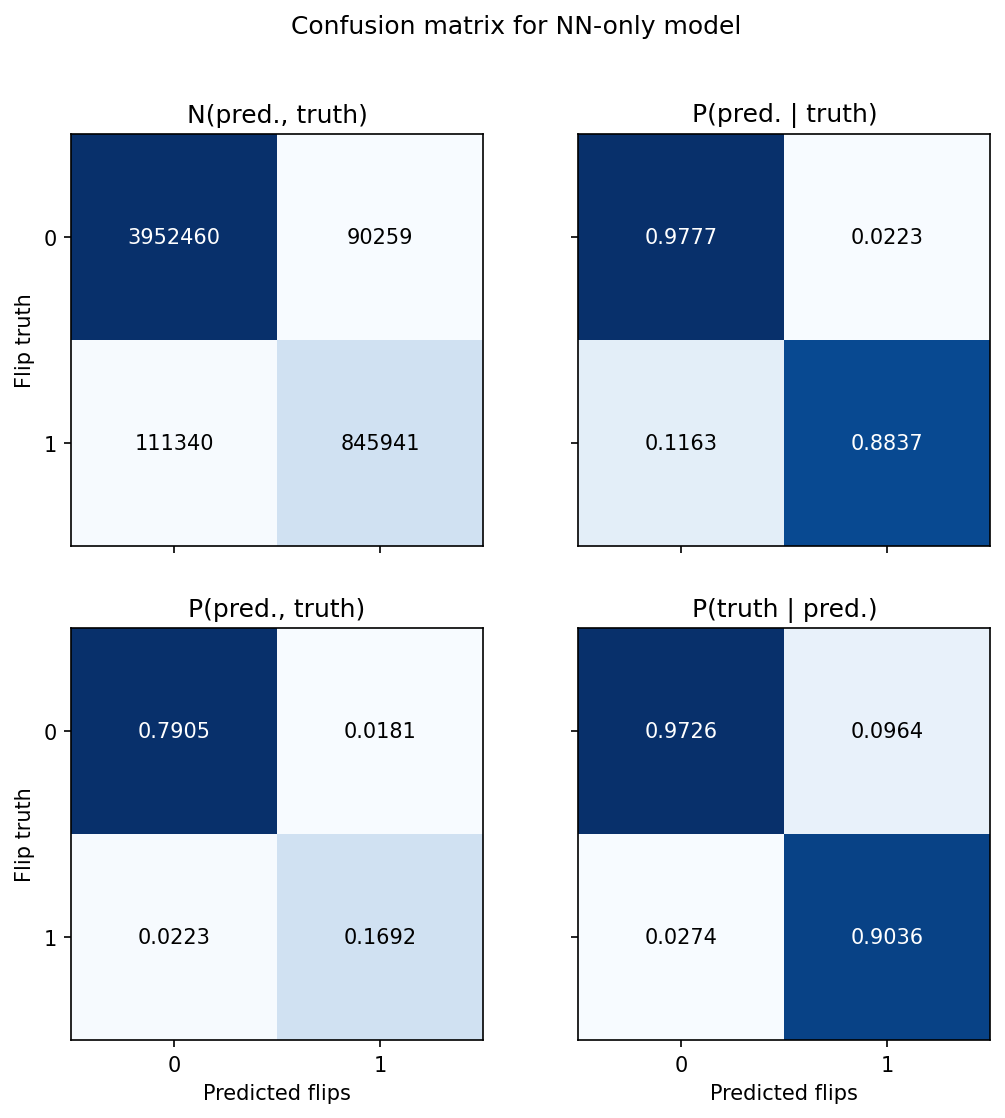

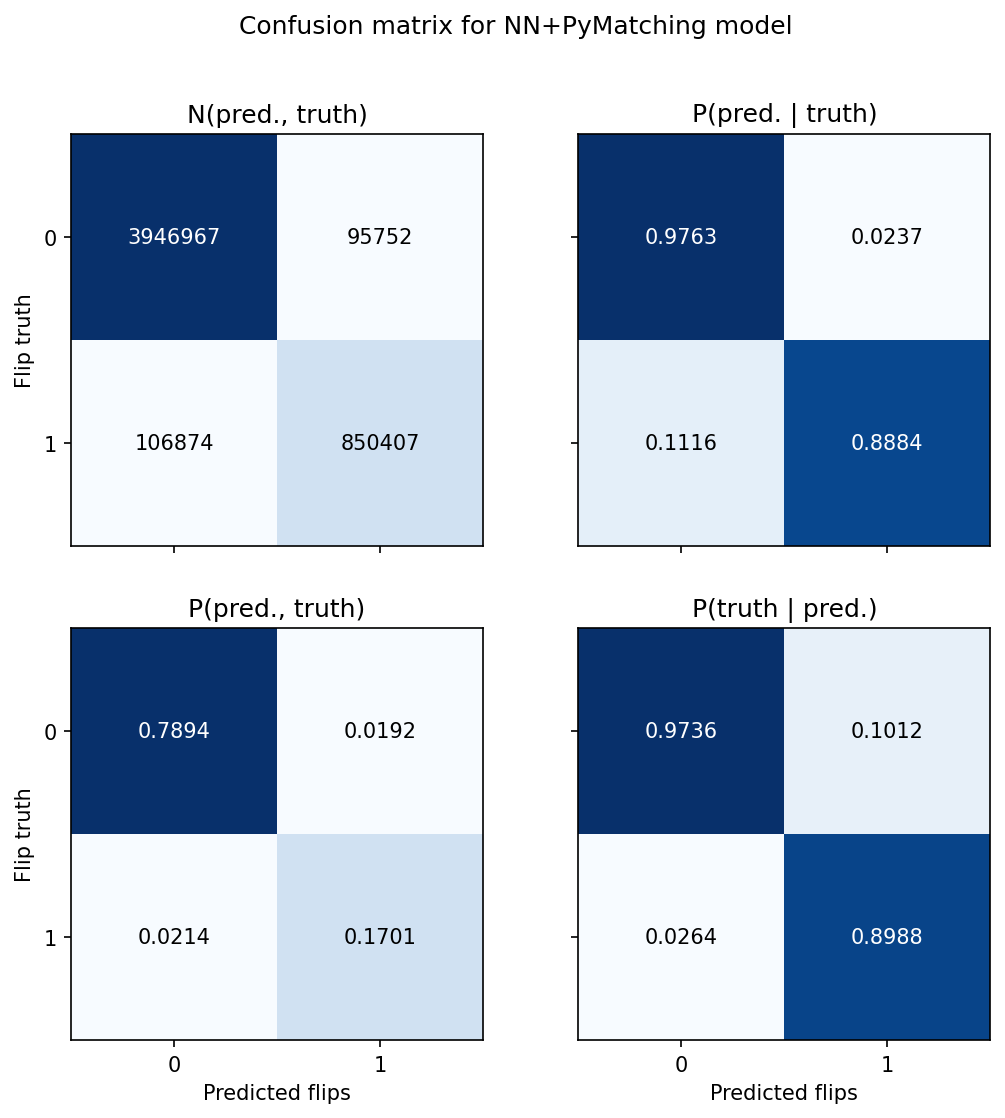

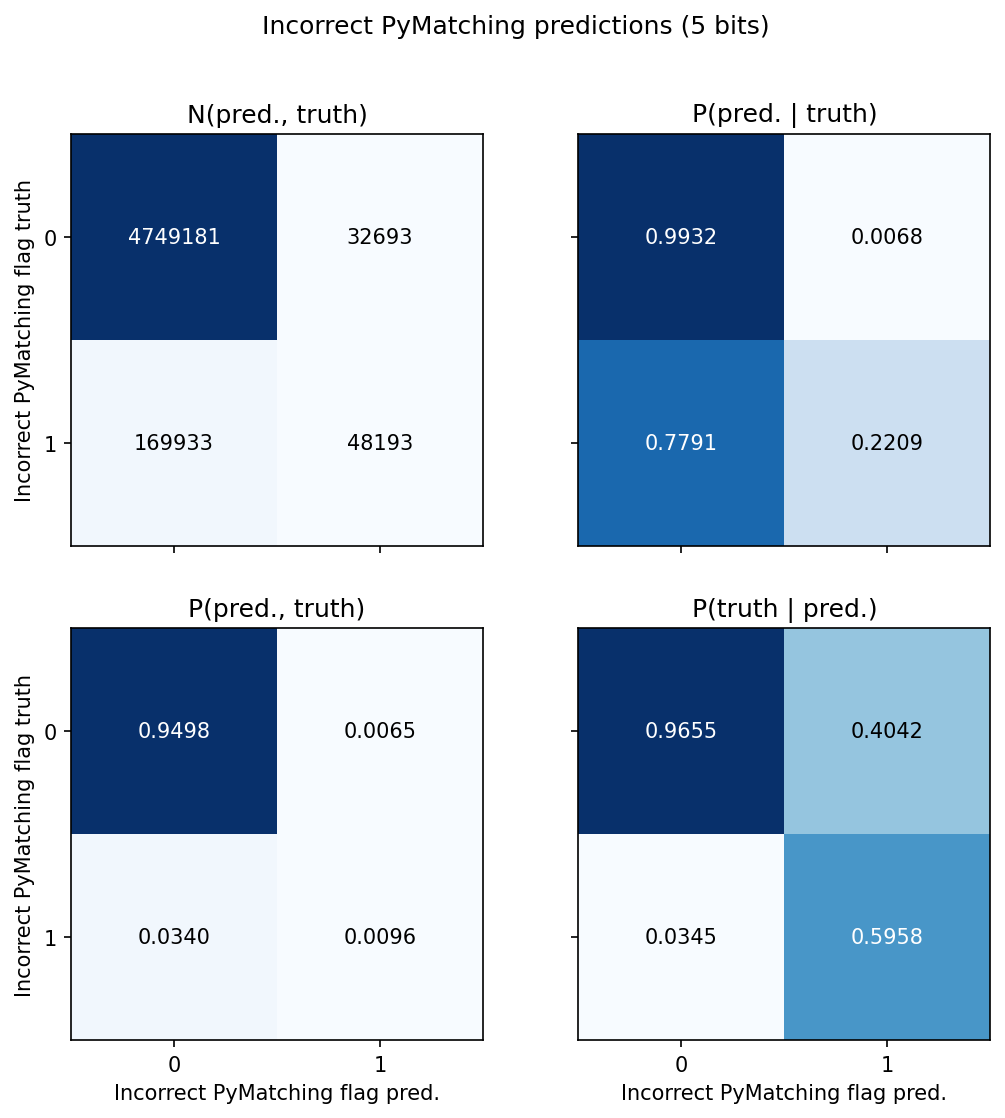

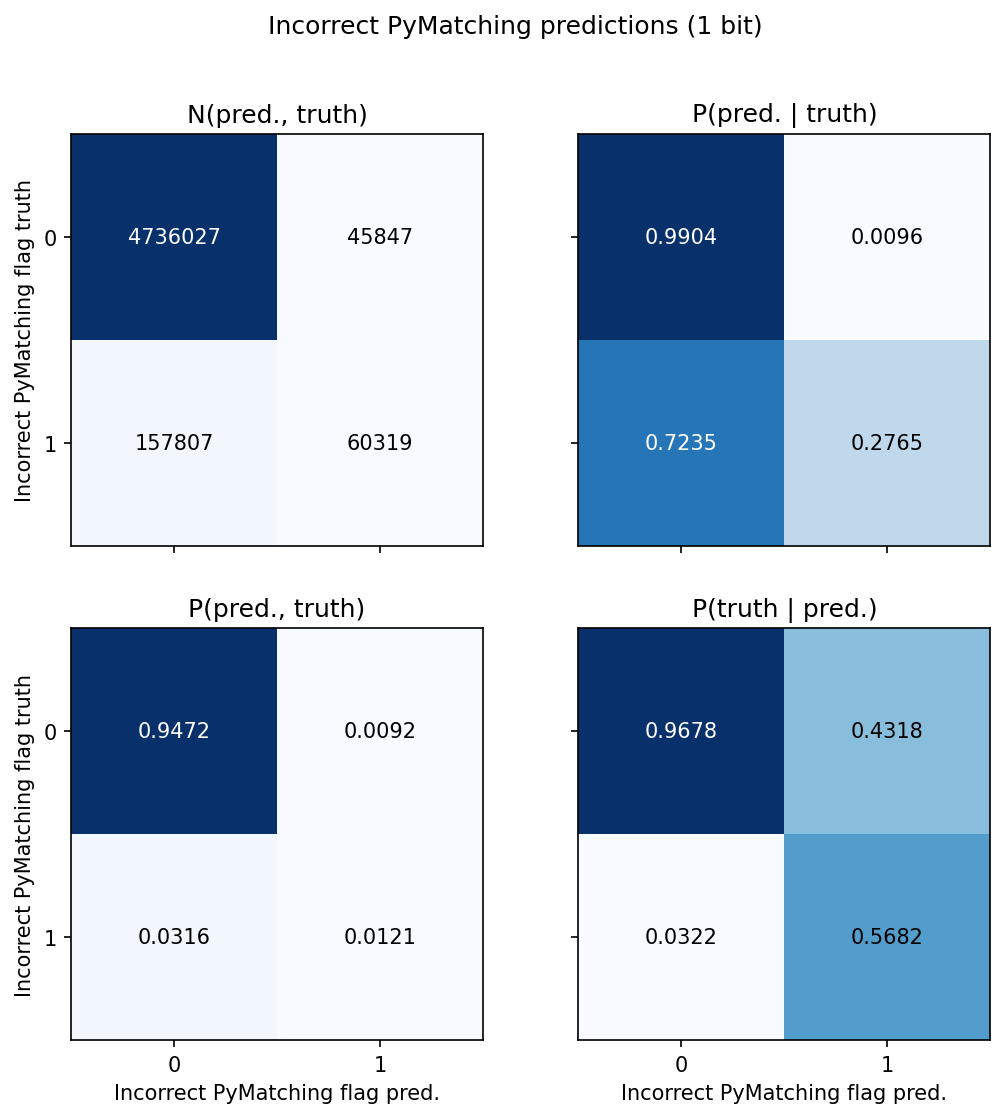

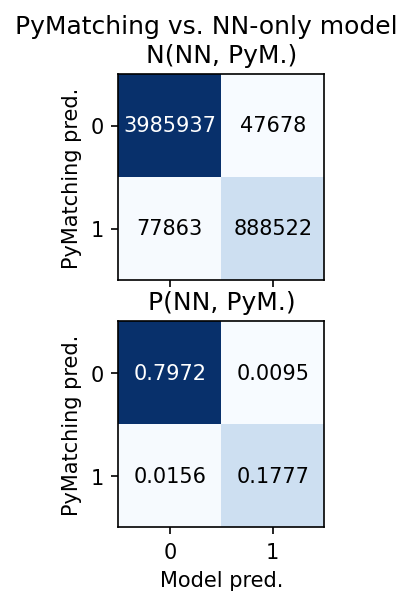

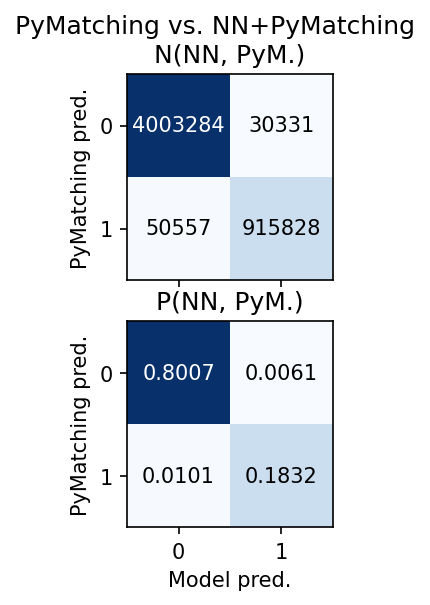

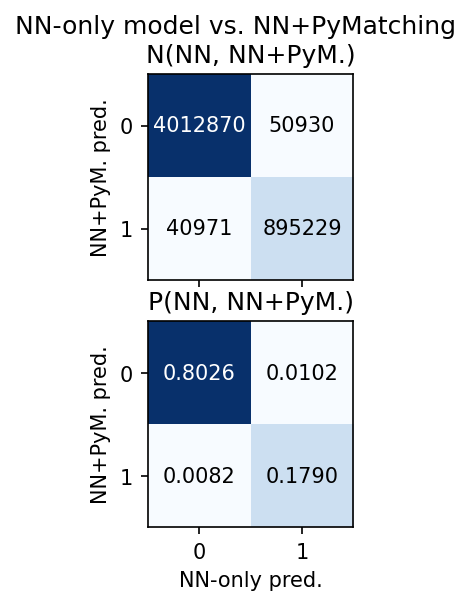

In [98]:
plot_confMat(confMat_nnonly_test, confMat_nnonly_test_condTruth, confMat_nnonly_test_condPred, "Confusion matrix for NN-only model", "Predicted flips", "Flip truth")
plot_confMat(confMat_wpym_test, confMat_wpym_test_condTruth, confMat_wpym_test_condPred, "Confusion matrix for NN+PyMatching model", "Predicted flips", "Flip truth")
plot_confMat(confMat_wpym_pym_test, confMat_wpym_pym_test_condTruth, confMat_wpym_pym_test_condPred, f"Incorrect PyMatching predictions ({d+1} bits)", "Incorrect PyMatching flag pred.", "Incorrect PyMatching flag truth")
plot_confMat(confMat_onlypym_test, confMat_onlypym_test_condTruth, confMat_onlypym_test_condPred, "Incorrect PyMatching predictions (1 bit)", "Incorrect PyMatching flag pred.", "Incorrect PyMatching flag truth")

plot_confMat(pym_vs_nnonly_test, None, None, "PyMatching vs. NN-only model", "Model pred.", "PyMatching pred.", pred_label = "NN", truth_label="PyM.")
plot_confMat(pym_vs_wpym_test, None, None, "PyMatching vs. NN+PyMatching", "Model pred.", "PyMatching pred.", pred_label = "NN", truth_label="PyM.")

plot_confMat(nnonly_vs_wpym_test, None, None, "NN-only model vs. NN+PyMatching", "NN-only pred.", "NN+PyM. pred.", pred_label = "NN", truth_label="NN+PyM.")

In [66]:
predbinned_n_flipped_wpym_test = np.zeros(8, dtype=np.int32)
predbinned_n_unflipped_wpym_test = np.zeros(8, dtype=np.int32)
for ev in range(predictions_pym_test.shape[0]):
  ibin = 0

  if incorrect_pym_pred_wpym_test[ev]==1: ibin = ibin + (1<<0)
  if predictions_pym_test[ev]==1: ibin = ibin + (1<<1)
  if flips_pred_wpym_test[ev]==1: ibin = ibin + (1<<2)

  truth = flips_truth_test[ev]
  if truth==1:
    predbinned_n_flipped_wpym_test[ibin] = predbinned_n_flipped_wpym_test[ibin] + 1
  else:
    predbinned_n_unflipped_wpym_test[ibin] = predbinned_n_unflipped_wpym_test[ibin] + 1
  
  predbinned_n_total_wpym_test = predbinned_n_flipped_wpym_test + predbinned_n_unflipped_wpym_test

In [69]:
print(predbinned_n_total_wpym_test)
print(predbinned_n_flipped_wpym_test)
print(predbinned_n_unflipped_wpym_test)

[4003284       0       2   50555       0   30331  915828       0]
[ 86397      0      1  20476      0  18114 832293      0]
[3916887       0       1   30079       0   12217   83535       0]


In [72]:
from scipy.stats import chi2 as chisq
from scipy.stats import binomtest

chisquared_cdf = chisq.cdf
chisquared_quantile = chisq.ppf

def get_CL_for_ndof(m2dll, ndof):
  return chisquared_cdf(m2dll, df=ndof)

VAL_CL_1SIGMA = get_CL_for_ndof(1., 1)
VAL_CL_2SIGMA = get_CL_for_ndof(4., 1)

def counting_interval(sw_total, swsq_total=None, CL = VAL_CL_1SIGMA):
  quant = (1.-CL)/2.
  count = 0.
  if swsq_total is None or swsq_total<=0.:
    count = sw_total
  else:
    count = sw_total**2/swsq_total
  vlow = (chisquared_quantile(quant, 2.*count) / 2. if count!=0. else 0.)
  vhigh = chisquared_quantile(1.-quant, 2.*(count+1.)) / 2.
  if count>0.:
    vlow = vlow * sw_total / count
    vhigh = vhigh * sw_total / count
  return (vlow, vhigh)

def efficiency_interval(sw_passed, sw_total, swsq_total=None, CL = VAL_CL_1SIGMA):
  normval = 1.
  if swsq_total is not None and swsq_total>0.:
    normval = sw_total/swsq_total
  passed = np.int32(sw_passed*normval)
  total = np.int32(sw_total*normval)
  if total==0:
    return (0., 0.)
  ci = binomtest(k=passed, n=total).proportion_ci(method='exact', confidence_level=CL)
  return (ci.low, ci.high)

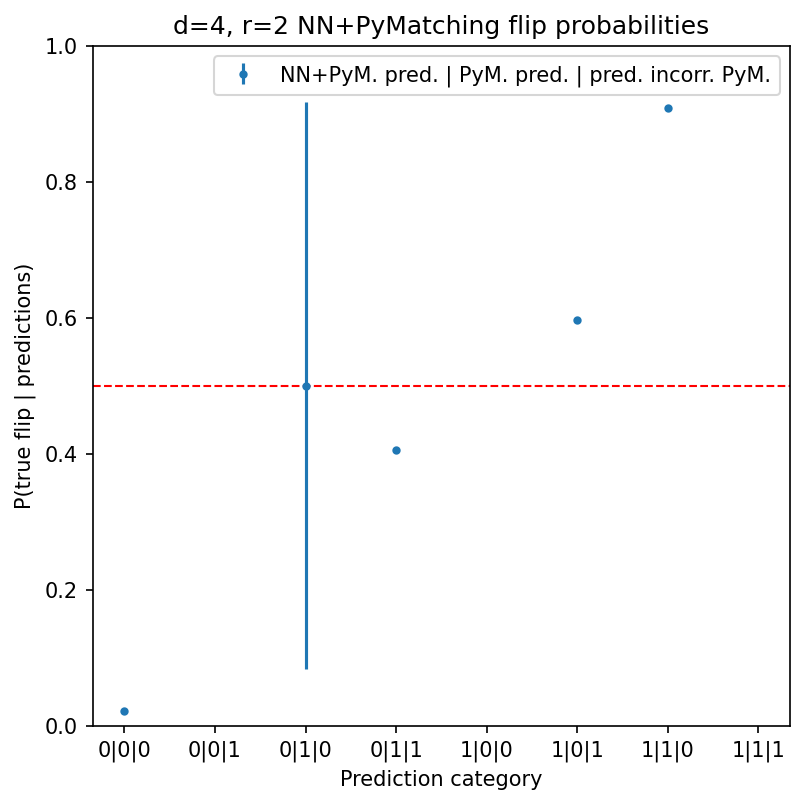

In [95]:
predbinned_eff_flipped_wpym_test = np.zeros(shape=(predbinned_n_flipped_wpym_test.shape[0], 3), dtype=np.float32)
for ibin in range(predbinned_n_flipped_wpym_test.shape[0]):
  if predbinned_n_total_wpym_test[ibin]==0.:
    predbinned_eff_flipped_wpym_test[ibin][:] = -1.
    continue
  predbinned_eff_flipped_wpym_test[ibin][0] = predbinned_n_flipped_wpym_test[ibin] / predbinned_n_total_wpym_test[ibin]
  predbinned_eff_flipped_wpym_test[ibin][1], predbinned_eff_flipped_wpym_test[ibin][2] = efficiency_interval(predbinned_n_flipped_wpym_test[ibin], predbinned_n_total_wpym_test[ibin])

xxlabels = []
for il in range(8):
  inc_pym = (il>>0)&1
  pym_pred = (il>>1)&1
  nn_pred = (il>>2)&1
  xxlabels.append(f"{nn_pred}|{pym_pred}|{inc_pym}")

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
ax.axhline(y=0.5, color='r', linestyle='--', linewidth=1)
ax.errorbar(
  x=xxlabels,
  y=predbinned_eff_flipped_wpym_test[:,0],
  yerr=[
    predbinned_eff_flipped_wpym_test[:,0]-predbinned_eff_flipped_wpym_test[:,1],
    predbinned_eff_flipped_wpym_test[:,2]-predbinned_eff_flipped_wpym_test[:,0]
  ],
  fmt='o',
  label='NN+PyM. pred. | PyM. pred. | pred. incorr. PyM.',
  markersize=3
)
ax.set_xlabel('Prediction category')
ax.set_ylabel('P(true flip | predictions)')
ax.set_title(f'd={d}, r={r} NN+PyMatching flip probabilities')
ax.legend()
ax.set_ylim([0, 1])
fig.set_dpi(150)